#  ISPC phase search match EXP

Search using experimental tabulated phases in AngeloDatabase Created using Angelo Notebook.

### Imports

In [36]:
from XRDXRFutils import (Phase, DatabaseXRD, DataXRF, DataXRD, SpectraXRD, GaussNewton,
    PhaseList, PhaseMap, PhaseSearch, PhaseMapSave, GammaMap, ChiMap)

from os.path import isdir
from os import makedirs
from shutil import rmtree

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares

from numpy import linspace, concatenate, sqrt, log, histogram, array, where, flip
from matplotlib.pyplot import (savefig, sca, vlines, show, fill_between, sca, legend, imshow,
    subplots, plot, xlim, ylim, xlabel, ylabel, cm, title, scatter, colorbar, figure, vlines)
from sklearn.cluster import KMeans, MiniBatchKMeans

from multiprocessing import Pool
import gc
from matplotlib import rcParams
from pathlib import Path

from PIL import Image

def f_linear(x,a,b):
    return a*x + b
def f_loss(x,t,y):
    return (x[0]*t + x[1]) - y

rcParams.update({
'image.origin': 'lower'
})

#### Define Paths and Spectra Parameters

In [2]:
#path_shared = '/home/shared/'
path_shared = '../../shared/'

path_xrd = path_shared + 'dataXRDXRF/MunchMuseum/M491/ProfiloXRD/' # XRD scan
path_xrf = path_shared + 'dataXRDXRF/MunchMuseum/M491/ProfiloXRF/labels/' # XRF scan
path_photo = path_shared + 'dataXRDXRF/MunchMuseum/M491/ProfiloFoto/' # photo of the scanned section
path_database = path_shared + 'Database/' # tabulated phases

subfolder_output = 'Munch/M491/ProfiloXRD/'
path_figures = 'figures/' + subfolder_output # figures generated by the script
path_results = 'results/' + subfolder_output # results generated by the script: raw data, tif maps
path_database_exp = 'databaseEXP/' + subfolder_output # experimental phases

min_theta = 21
max_theta = 56
min_intensity = 0.1 # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)

sigma = 0.2

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    for path_sel in [path_figures, path_results, path_database_exp]:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [3]:
for path_sel in [path_figures, path_results, path_database_exp]:
    if not isdir(path_sel):
        makedirs(path_sel)

## Read XRD Data and Database

Loading: ../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/xrd.h5
Shape of data: (95, 170, 1280)
a: -1214.7 s: 1952.7 beta: 51.663
Phases in database: 318
Phases in databaseEXP: 0


/Users/dariozappala/.local/lib/python3.8/site-packages/XRDXRFutils/database.py:176: UserWarning: No files found
  warnings.warn('No files found')


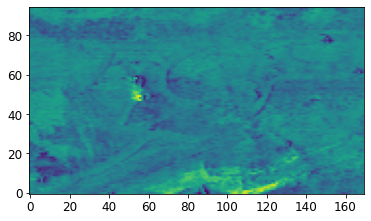

In [39]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5')
except:
    print('Reading from raw data.')
    data = DataXRD().read_params(path_xrd + 'Scanning_Parameters.txt').read(path_xrd).calibrate_from_file(path_xrd + 'calibration.ini').remove_background(std = 5).save_h5(path_xrd + 'xrd.h5')
print(f'Shape of data: {data.shape}')
print("a: %.1f s: %.1f beta: %.3f"%(data.opt[0],data.opt[1],data.opt[2]))

database = DatabaseXRD().read_cifs(path_database)
databaseExp = DatabaseXRD().read_cifs(path_database_exp)
print('Phases in database:',len(database))
print('Phases in databaseEXP:',len(databaseExp))

figure(figsize=(6,4))
im = imshow(data.data.sum(axis=2))
show()

# Read XRF maps

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [10]:
data_xrf = DataXRF()
data_xrf.read_tiff(path_xrf)
data_xrf.labels = flip(data_xrf.labels, axis = xrf_axes_flip)
y_x_ratio = data_xrf.labels.shape[0] / data_xrf.labels.shape[1]
print(f'Found {data_xrf.labels.shape[2]} images:')
print(', '.join([name for name in data_xrf.metadata['labels']]))

Found 24 images


### Correct burnt pixels and wrong scale in each XRF map; also calculate normalized XRF maps
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [11]:
qtl = 0.999
#qtl = 1

qtl_calculated = quantile(data_xrf.labels, qtl, axis = (0, 1), keepdims = True)
n_corrected = (data_xrf.labels > qtl_calculated).sum() / data_xrf.labels.shape[-1]
data_xrf.labels = clip(data_xrf.labels, None, qtl_calculated)
print(f'{n_corrected:.0f} pixels out of {data_xrf.labels.shape[0] * data_xrf.labels.shape[1]} were corrected on average in each XRF map.')

data_xrf.labels -= data_xrf.labels.min(axis = (0, 1), keepdims = True)

maps_xrf_norm = data_xrf.labels / data_xrf.labels.max(axis = (0, 1), keepdims = True)

17 pixels out of 16150 were corrected on average in each XRF map.


## Read database
This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [42]:
hydrocerussite = database['Hydrocerussite'][0]
lazurite = database['Lazurite'][0]
cinnabar = database['Cinnabar'][1]
calcite = database['Calcite'][0]
cobalt_alluminate = database['Al2 Co O4'][0] # same formula as Spinel
spinel = database['Spinel'][0]
lead_cromate_oxide = database['Cr O5 Pb2'][0]
hematite = database['Hematite'][0]
cristobalite = database['Cristobalite'][0]
goethite = database['Goethite'][0]
Mn3_O4 = database['Mn3 O4'][0]
barite = database['Barite'][0]
greenockite = database['Greenockite'][0] # same formula as Hawleyite
hawleyite = database['Hawleyite'][0]

phases = PhaseList([hydrocerussite, lazurite, cinnabar, barite, greenockite, hawleyite])

phases.get_theta(min_intensity=min_intensity,
                 min_theta = min_theta,
                 max_theta = max_theta,
                first_n_peaks = first_n_peaks)

if 'pmax_a' in locals():
    data.opt[0] = pmax_a
    data.opt[1] = pmax_s

# Search database

In [43]:
elements_chosen = ['Cr']

for v,k in sorted(database.items()):
    p = k[0]
    if '_chemical_formula_sum' in p:
        if all(e in p['_chemical_formula_sum'] for e in elements_chosen):
            if '_chemical_name_mineral' in p:
                print(p['_chemical_name_mineral'] + ', ', end = '\t')
            print(p['_chemical_formula_sum'] + ', ', end = '\t')
            print(len(k))

Ba Cr O4, 	1
Cr O4 Pb, 	1
Cr O4 Sr, 	8
Cr O4 Sr2, 	1
Cr O5 Pb2, 	3
Cr2 O3, 	1
Cr2 O4 Sr, 	1
Crocoite, 	Cr O4 Pb, 	3
Eskolaite, 	Cr2 O3, 	23


### Plot XRF of selected element

In [14]:
#%matplotlib inline
%matplotlib qt

element_chosen = 'Ca'
rcParams['font.size'] = 12

for i, label in enumerate(data_xrf.metadata['labels']):
    #if element_chosen in label:   # search for the given string in XRF label
    if element_chosen + '_' in label:   # search for the given string + '_' in XRF label
        fig, ax  = subplots(figsize=(10,10))
        title(label)
        im = imshow(data_xrf.labels[..., i])
        colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
show()

In [15]:
%%time
cmap = ChiMap().from_data(data, phases, sigma = sigma)

CPU times: user 703 ms, sys: 98 ms, total: 801 ms
Wall time: 862 ms


In [16]:
%%time
cmap = cmap.search()

Using 8 CPUs
CPU times: user 8.28 s, sys: 1.68 s, total: 9.96 s
Wall time: 19.1 s


In [17]:
%%time
L1loss, MSEloss, overlap_area = cmap.metrics()
rescaling = data.rescaling

Using 8 CPUs
CPU times: user 4.38 s, sys: 406 ms, total: 4.79 s
Wall time: 5.7 s


In [18]:
chi = cmap.chi()

In [19]:
chi = where(chi > 1,5,chi)

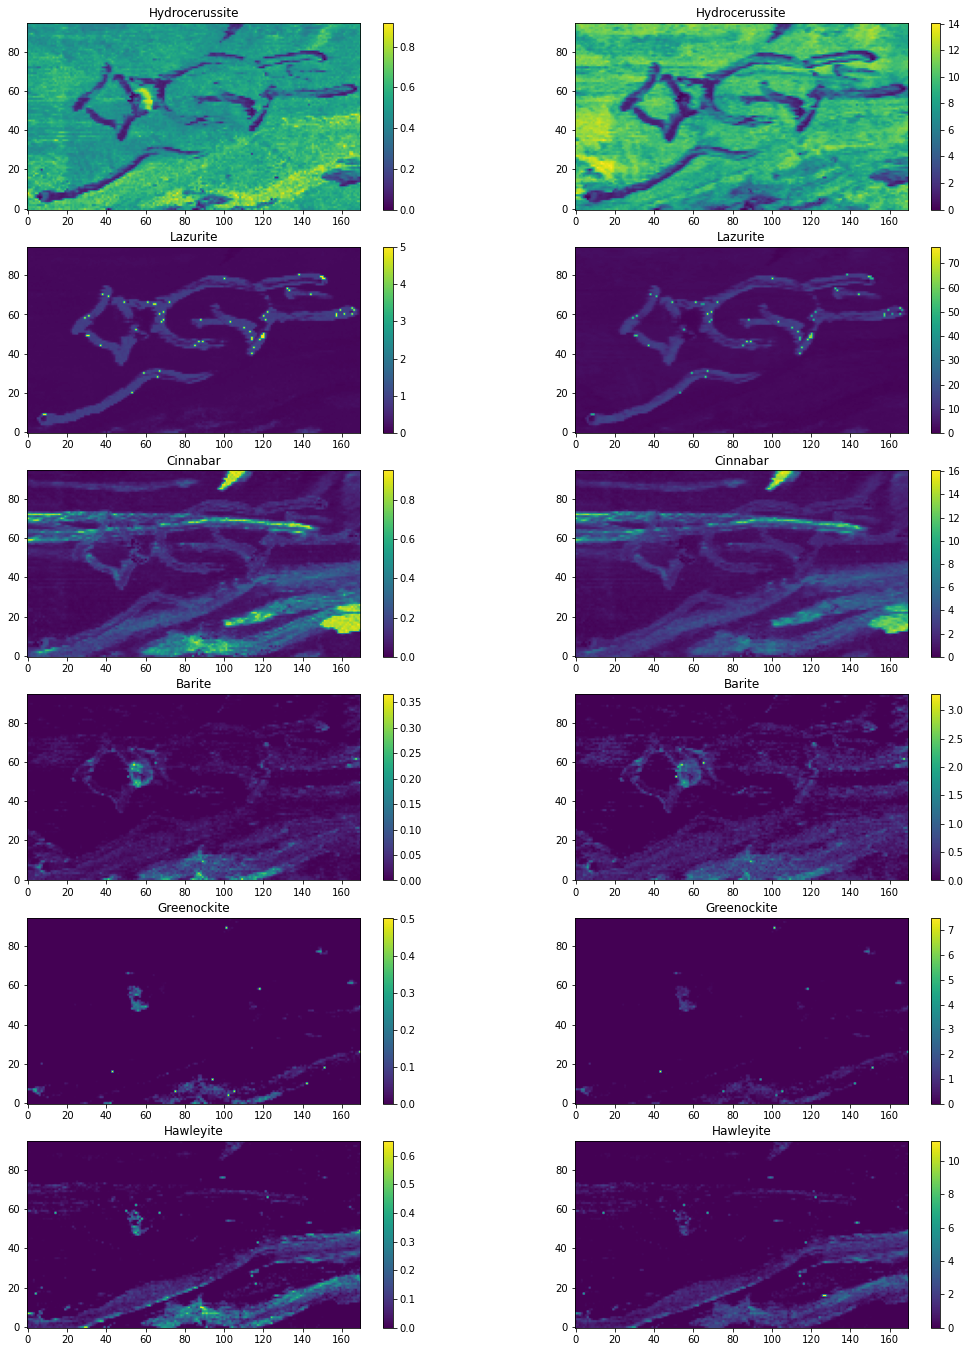

In [20]:
%matplotlib inline

fig, ax = subplots(len(cmap.phases), 2, figsize=(18,24))

rescaled_chi = chi * rescaling**0.5

for i,phase in enumerate(cmap.phases):
    ax[i,0].set_title(phase.label)
    p = ax[i,0].imshow(chi[...,i],vmin=0)
    colorbar(p,ax = ax[i,0])
    
    ax[i,1].set_title(phase.label)
    p = ax[i,1].imshow(rescaled_chi[...,i],vmin=0)
    colorbar(p,ax = ax[i,1])
    
show()

# Save PNG

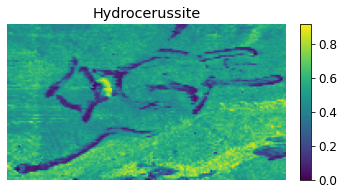

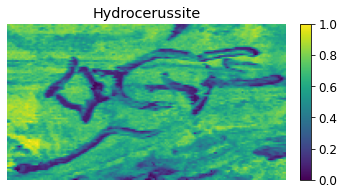

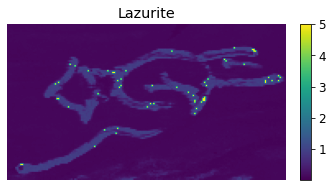

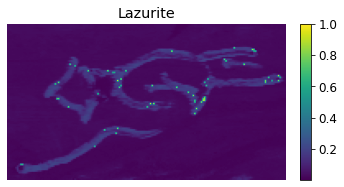

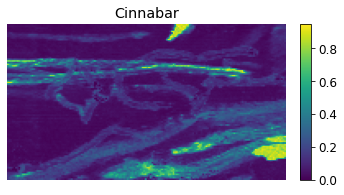

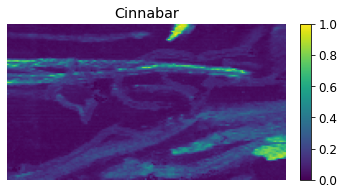

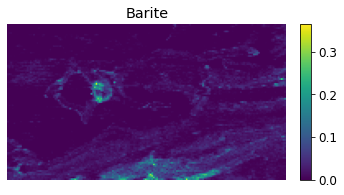

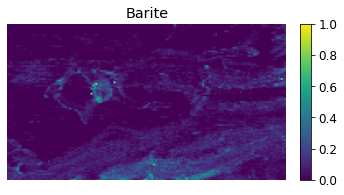

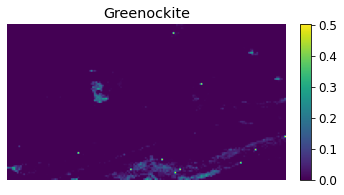

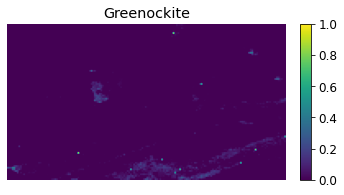

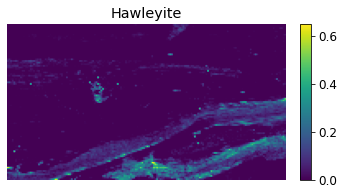

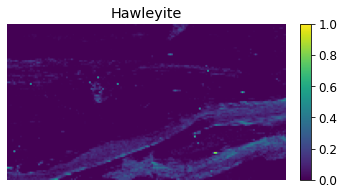

In [21]:
rcParams['font.size'] = 12
Path(path_figures).mkdir(parents=True, exist_ok=True)

for i, phase in enumerate(cmap.phases):
    fig, ax  = subplots(figsize=(5,3))

    im = ax.imshow(chi[...,i])
    
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    
    ax.set_title(phase.label)
    ax.axis('off')

    savefig(path_figures + phase.label + '_chi.png', bbox_inches = 'tight', dpi = 300, transparent = False)
    
    fig, ax  = subplots(figsize=(5,3))

    im = ax.imshow(rescaled_chi[...,i]/rescaled_chi[...,i].max())
    
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    
    ax.set_title(phase.label)
    ax.axis('off')

    savefig(path_figures + phase.label + '_rescaled_chi.png', bbox_inches = 'tight', dpi = 300, transparent = False)

show()

# Save TIFF

In [22]:
Path(path_results).mkdir(parents=True, exist_ok=True)

for i, phase in enumerate(cmap.phases):
    uint_img = (chi[...,i]/chi[...,i].max() * 255).astype('uint8')[::-1]
    
    img = Image.fromarray(uint_img)   
    img.save(path_results + phase.label + '.tiff')
    
    uint_img = (rescaled_chi[...,i]/rescaled_chi[...,i].max() * 255).astype('uint8')[::-1]
    
    img = Image.fromarray(uint_img)
    img.save(path_results + phase.label + '_rescaled.tiff')

### Histogram of $a$

If $a$ is spead over too large area it might be that the phases are to right or a phase is missing

CPU times: user 30.3 ms, sys: 4.88 ms, total: 35.2 ms
Wall time: 32.9 ms


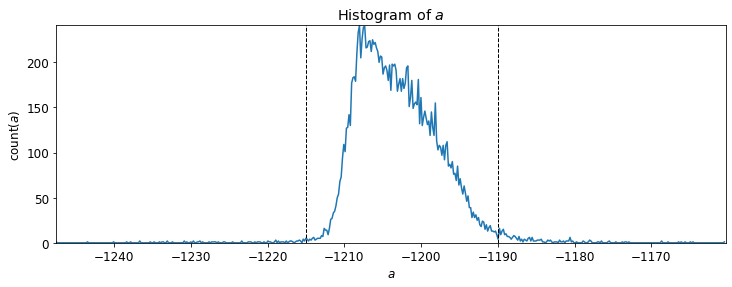

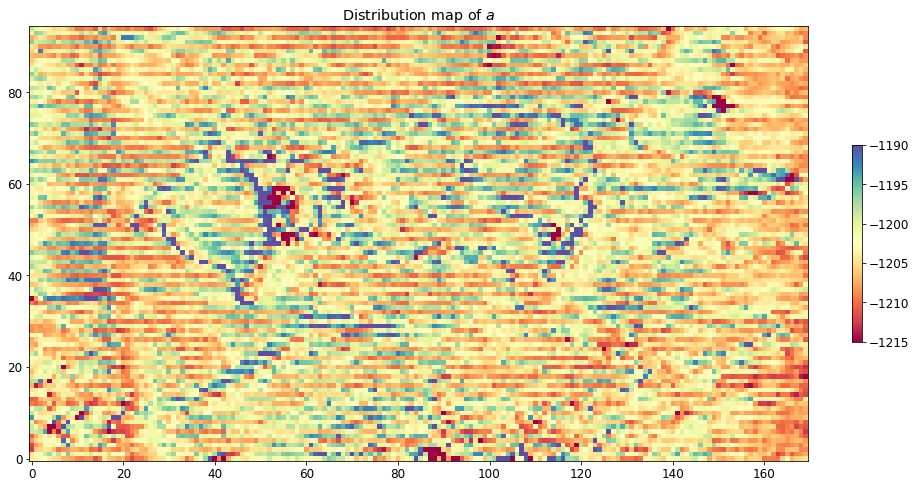

In [24]:
%%time
opt = cmap.opt()
a = opt[...,0]
s = opt[...,1]

vmin = -1215
vmax = -1190

h,b = histogram(a,bins=512)

figure(figsize=(12,4))

plot(b[:-1],h)
xlim(b[0],b[-1])
ylim(0,h.max())

vlines(vmin,0,h.max(),'k',ls='--',lw=1)
vlines(vmax,0,h.max(),'k',ls='--',lw=1)

xlabel('$a$')
ylabel(r'count($a$)')
title(r'Histogram of $a$')

figure(figsize=(16,8))
title('Distribution map of $a$')
im = imshow(a,cmap='Spectral',vmin=vmin,vmax=vmax)
colorbar(im,fraction=0.011)

## Plotting the $a,s$ dependence

There is a slight notion of a second $as$ dependence but it is weak.

Linear: [ -1.30870603 365.29577332]
Cauchy: [ -0.94828701 800.18513324]
mean a,s: -1202.9739134726767 1939.6349853727393
most probable a,s: -1208.0379680988688 1945.7518414854817


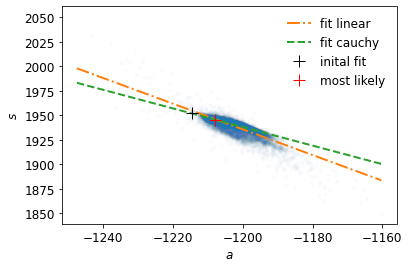

In [32]:
%matplotlib inline
rcParams['font.size'] = 12

opt,var = curve_fit(f_linear,a.flatten(),s.flatten())
res = least_squares(f_loss,x0=opt,args=(a.flatten(),s.flatten()),loss='cauchy')

linear_y = f_linear(a.flatten(),*opt)
cauchy_y = f_linear(a.flatten(),*res['x'])

print('Linear:',opt)
print('Cauchy:',res['x'])

plot(a.flatten(),s.flatten(),'.',alpha=0.01)

x = linspace(a.min(),a.max(),10)
plot(x,f_linear(x,*opt),'-.',lw=2,label='fit linear')
plot(x,f_linear(x,*res['x']),'--',lw=2,label='fit cauchy')
plot(data.opt[0],data.opt[1],'k+',ms=12,label='inital fit')

pmax_a = b[h.argmax()]
pmax_s = f_linear(pmax_a, *res['x'])

print('mean a,s:',a.mean(), s.mean())
print('most probable a,s:', pmax_a, pmax_s)

plot(pmax_a,pmax_s,'r+',ms=12,label='most likely')

legend(frameon=False)
xlabel(r'$a$')
ylabel(r'$s$')
show()

# Inspect point with phase decomposition

[-1205.38005113  1943.56710089    51.66346438]


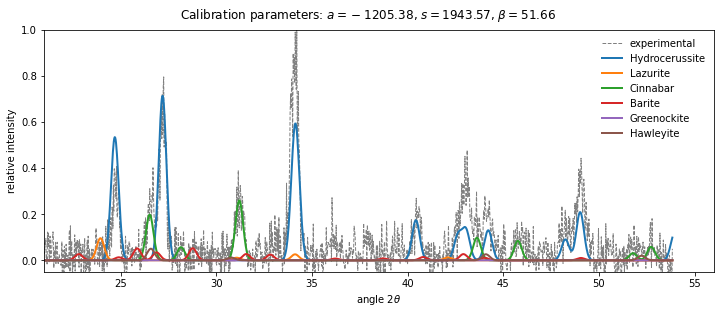

In [31]:
%matplotlib inline
selected = cmap.get_pixel(120, 6)

fig, ax = subplots(figsize = (12,4))
fig.subplots_adjust(hspace = 0.4, bottom = 0.06, top = 0.9)

print(selected.opt)
fig.suptitle(r'Calibration parameters: $a = %.2f$, $s=%.2f$, $\beta=%.2f$'%(selected.opt[0], selected.opt[1], selected.opt[2]))

profiles = selected.z_decomposed()

selected[0].plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')

for i in range(len(selected)):
    g = selected[i]
    
    s_chi = selected.chi[0]   
    plot(g.theta, profiles[:, i], lw = 2, label = g.label)

    legend(frameon=False)
    ax.set_ylim(-0.05, 1)
    ax.set_xlim(min_theta, max_theta)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    
show()